In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from scipy import signal
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Global setpoints 
columns_input = ['line_2_inp_flow','line_2_out_flow','power'
                ]
columns_analyze = ['line_2_inp_flow','power','target_delta_flow'
                ]

n_mean_rolling = 2 #Take only each X seconds

columns_fit = ['line_2_inp_flow','power'] 

csv_separator = ';' #'\t'

n_prev = 8
pca_en = False
plnm = False
pca = PCA(0.99, random_state = RANDOM_STATE)
scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))
#scaler = MinMaxScaler(feature_range=(0, 1)) 
polynom = PolynomialFeatures(degree=2)
target_name = 'target_delta_flow'

In [5]:
#Specific preprecessor
def preprocess_data(data):  
    """
    Custom preprocessing of DataFrame
    """
    data['target_delta_flow'] = (data['line_2_out_flow'] - data['line_2_inp_flow'])
    data.dropna(inplace=True)

b, a = signal.butter(3, 0.02)
    
def filtering(data_column):
    return signal.filtfilt(b, a, np.array(data_column))

In [6]:
#Global function for set preparation
#X,Y data: floating window 0-30 second

def _load_data(data_X,data_y, n_prev):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    
    for i in range(len(data_X)-n_prev+1):
        docX.append(data_X[i:i+n_prev])
        docY.append(np.array(data_y)[i+n_prev-1])
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY 


def _pca_scaler_data(data_X,fit_en,pca_en,plnm):  
    if len(data_X) !=0:
        if fit_en:
            X_tr_sc  = scaler.fit_transform(data_X)
            if plnm:
                X_tr_sc = polynom.fit_transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.fit_transform(X_tr_sc)
        else:
            X_tr_sc  = scaler.transform(data_X)
            if plnm:
                X_tr_sc  = polynom.transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.transform(X_tr_sc)   
    else:
        X_tr_sc = np.array(data_X)
        
    if len(data_X) !=0:
        X_tst_sc = scaler.transform(data_X)
        if plnm:
            X_tst_sc = polynom.transform(X_tst_sc)
        if pca_en:
            X_tst_sc = pca.transform(X_tst_sc)
    else:
        X_tst_sc = np.array(data_X)
    return X_tst_sc 

def train_test_split(X_inp,y_inp,test_size=0.2):  
    """
    This just splits X,y data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train, y_train = X_inp[0:ntrn,:] ,y_inp[0:ntrn]
    X_test, y_test   = X_inp[ntrn:,:] ,y_inp[ntrn:]
    return (X_train, y_train), (X_test, y_test)
def X_train_test_split_df(X_inp,test_size):  
    """
    This just splits X data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train = X_inp.iloc[0:ntrn] 
    X_test  = X_inp.iloc[ntrn:] 
    return (X_train, X_test)

def plot_predicted(X_inp,y_inp,model,range_low = 0,range_high=1,range_up=None,range_down=None, extra_plot=None):  
    num_elem = X_inp.shape[1]*X_inp.shape[2]
    predicted = model.predict(X_inp.reshape(-1,num_elem))  #for linear models model.predict(X_inp.reshape(-1, 18))  
    
    n_hi = round((len(X_inp)+num_elem) * range_high)
    n_low = round((len(X_inp)+num_elem) * range_low)
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title('Measuring values') 
        df_pred = pd.DataFrame(np.insert(predicted,0,[0 for i in range(num_elem)]),columns=['%s predicted'%target_name])
        df_real = pd.DataFrame(np.insert(y_inp[:,],0,[0 for i in range(num_elem)]),columns=['%s real'%target_name])
        df_pred = df_pred.iloc[n_low:n_hi]
        df_real = df_real.iloc[n_low:n_hi]
        plt.plot(df_real['%s real'%target_name]); #columns=['%s_real'%target_name]
        plt.plot(df_pred['%s predicted'%target_name]); #['%s_predicted'%target_name]
        plt.ylim([range_down,range_up])
        plt.legend(['%s predicted'%target_name,'%s real'%target_name])
        #for k in range(X_train.shape[0]):
        #    plt.plot(np.insert(X_train[k,:,0],0,[0 for i in range(k)]))
    if extra_plot:
        with plt.style.context('bmh'):    
            plt.figure(figsize=(15, 8))
            plt.title('Additional trends') 
            for j in extra_plot:
                df_extra = pd.DataFrame(X_inp[:,-1,j])
                df_extra = df_extra.iloc[n_low:n_hi]
                plt.plot(df_extra); 
            plt.ylim([range_down,range_up])
            
def prepare_data_set(file_name,test_size=0.2,n_prev = 60, plnm = False,fit_en=False,pca_en = True,merge = False):
    
    frame_df = []

    for j in file_name:
        inp_data_frame = pd.read_csv(j, sep=csv_separator ,header = 0)
        
        print(j)
        print("Initial lenght of %a data file is %s"%(j,len(inp_data_frame)))

        inp_data_frame.columns = columns_input
        
        have_nan = inp_data_frame.isnull().values.any()
        
        #Preprocess
        preprocess_data(inp_data_frame)
        
        #Filter used columns
        inp_data_frame = inp_data_frame[columns_analyze] 
        
        #Removing NAN values
        if have_nan:
            #Finding gaps in row index - do not use the gaps for analyse
            #Some trick to find the rows where index jumps
            gap_indexes = np.where(np.roll(inp_data_frame.index, -1)-inp_data_frame.index>1)[0]+1 

            #Split initial data by gaps
            prev_gap_index=0
            for gap_index in gap_indexes:
                cut = inp_data_frame.iloc[prev_gap_index:gap_index]
                prev_gap_index = gap_index
                if len(cut)>=n_mean_rolling*n_prev:
                    frame_df.append(cut)
                
            if len(inp_data_frame)-gap_indexes[-1]>=n_mean_rolling*n_prev:
                frame_df.append(inp_data_frame.iloc[gap_indexes[-1]:])
        else:
            frame_df.append(inp_data_frame)
        
        #Counting sub blocks    

    if not merge:
        for n in range(len(frame_df)):
            for k in frame_df[n].columns:
                frame_df[n][k] = filtering(frame_df[n][k])
                frame_df[n][k] = frame_df[n][k].rolling(n_mean_rolling).mean() #Add rolling mean   
                
            frame_df[n] = frame_df[n][frame_df[n].index%n_mean_rolling == 0].iloc[1:] #Filtering
            print("Length of filtered sub data piece is %s"%(len(frame_df[n]))) 
    else:
        df_ = pd.concat(frame_df)
        df_ = df_.reset_index(drop=True)
        for k in df_.columns:
            df_[k] = filtering(df_[k])
            df_ = df_[k].rolling(n_mean_rolling).mean() #Добавляем скользящие средние
        df_ = df_[df_.index%n_mean_rolling == 0].iloc[1:] #Прореживаем
        print("Total length of merged and filtered data is %s"%(len(df_))) 
        
    if merge:
        y = df_[target_name]
        X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
        X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
        X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
        if len(X_train_scaled) ==0:
            X_scaled = X_test_scaled
        elif len(X_test_scaled) ==0:
            X_scaled = X_train_scaled
        else:
            X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
        X_,y_ = _load_data(X_scaled,y,n_prev)
    else:
        frame_X,frame_y = [],[]
        df_ = pd.concat(frame_df)
        df_ = df_.reset_index(drop=True)
        print("Total length of Unmerged and filtered data is %s"%(len(df_))) 
        y = df_[target_name]
        X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
        X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
        X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
        if len(X_train_scaled) ==0:
            X_scaled = X_test_scaled
        elif len(X_test_scaled) ==0:
            X_scaled = X_train_scaled
        else:
            X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
            
        n=0
        pointer_beg = 0
        pointer_end = 0
        for v in frame_df:
            pointer_end += len(v)
            X_part,y_part = _load_data(X_scaled[pointer_beg:pointer_end],y[pointer_beg:pointer_end],n_prev)
            pointer_beg += len(v)
            frame_X.append(X_part)
            frame_y.append(y_part)
            n+=1
        X_,y_ = np.concatenate(frame_X),np.concatenate(frame_y)  
    
    (X_train_, y_train_), (X_test_, y_test_) = train_test_split(X_,y_,test_size=test_size) 
    
    print("Train X shape",X_train_.shape)
    print("Train y shape",y_train_.shape)
    print("Test X shape",X_test_.shape)
    print("Test y shape",y_test_.shape)

    return df_,X_train_,y_train_,X_test_,y_test_
    


In [8]:
df,X_train,y_train,X_test,y_test = prepare_data_set(['./data/export_20171026.txt','./data/export_20171027.txt'],\
                                                    test_size=0.2,n_prev = n_prev,fit_en=True,plnm = plnm, pca_en = pca_en,merge = False)


df

./data/export_20171026.txt
Initial lenght of './data/export_20171026.txt' data file is 266712
./data/export_20171027.txt
Initial lenght of './data/export_20171027.txt' data file is 607316
Length of filtered sub data piece is 835
Length of filtered sub data piece is 1178
Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Length of filtered sub data piece is 26999
Length of filtered sub data piece is 23999
Length of filtered sub data piece is 24652
Length of filtered sub data piece is 26999
Total length of Unmerged and filtered data is 434649
Train X shape (347613, 8, 2)
Train y shape (347613,)
Test X shape (86903, 8, 2)
Test y shape (86903,)


,line_2_inp_flow,power,target_delta_flow
0,313.304703,96.904565,3.109875
1,313.241537,96.084361,3.157249
2,313.175521,95.289556,3.206284
3,313.107204,94.527952,3.256472
4,313.037213,93.807020,3.307241
...,...,...,...
434644,311.171000,104.468000,4.286000
434645,311.171000,104.468000,4.286000
434646,311.171000,104.468000,4.286000
434647,311.171000,104.468000,4.286000


In [15]:
df = pd.read_csv('./data/export_20171026.txt', sep=csv_separator ,header = 0 )
print("Initial lenght of data is %s"%(len(df)))
df.columns = columns_input
df = df.iloc[0:2200]
preprocess_data(df)
indexes = np.where(np.roll(df.index, -1)-df.index>1)[0]+1

res = []
n_prev=0
for i in indexes:
    cut = df.iloc[:i]
    if len(cut)>=2:
        res.append(cut)
    
if len(df)-indexes[-1]>=2:
    res.append(df.iloc[indexes[-1]:])


Initial lenght of data is 266712


In [8]:
for k in res[0].columns:
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title("Measuring %s"%k)
        plt.plot(res[0][k]);
        plt.legend(loc="best")

NameError: name 'res' is not defined

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


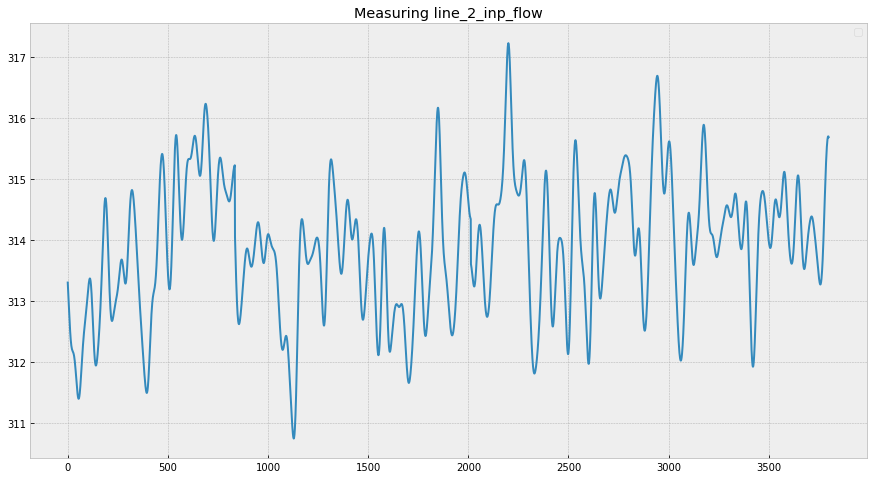

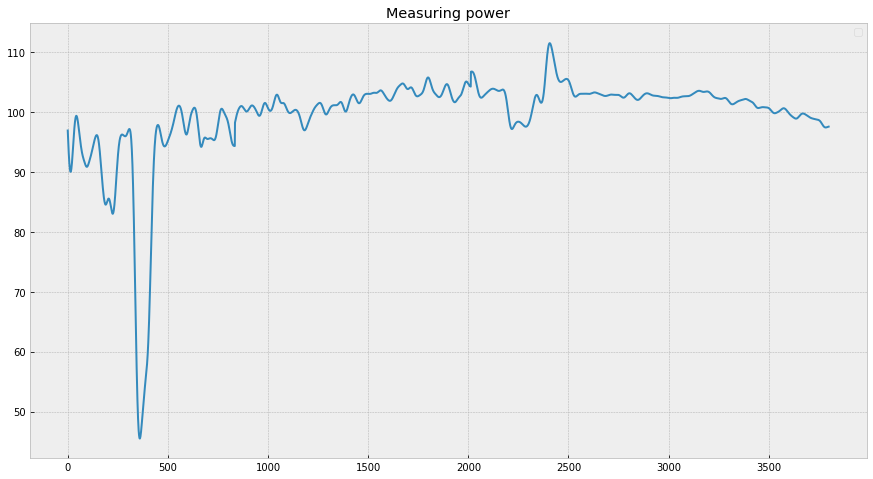

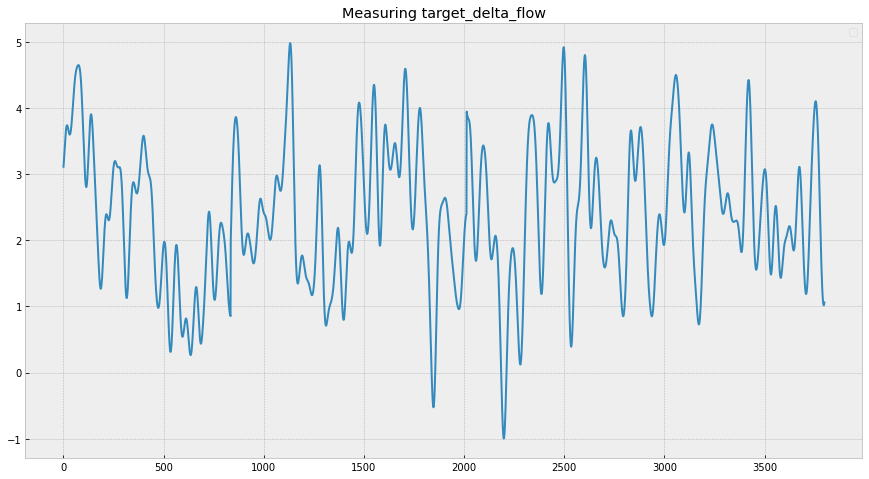

In [9]:
#Plot data
for k in df.columns:
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title("Measuring %s"%k)
        plt.plot(df[k].iloc[0:3800]);
        plt.legend(loc="best")

No handles with labels found to put in legend.


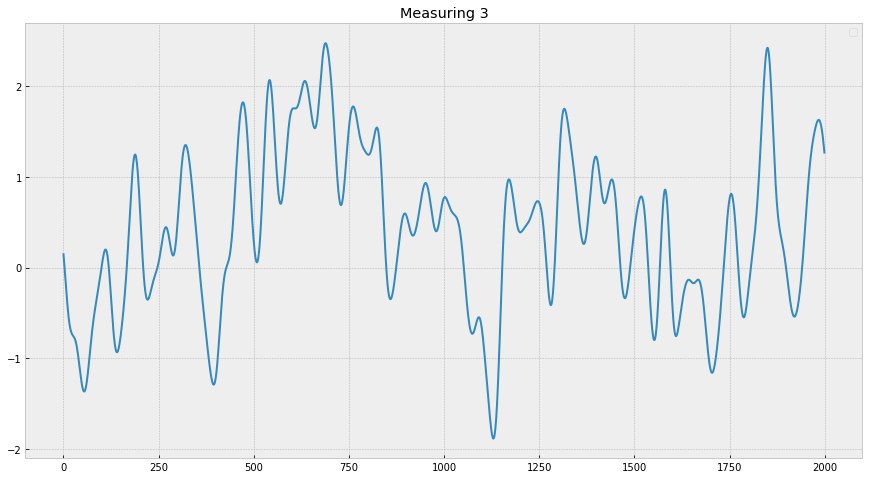

In [30]:
#Plot data
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title("Measuring %s"%k)
    plt.plot(X_train[0:2000,0,0]);
    plt.legend(loc="best")

No handles with labels found to put in legend.


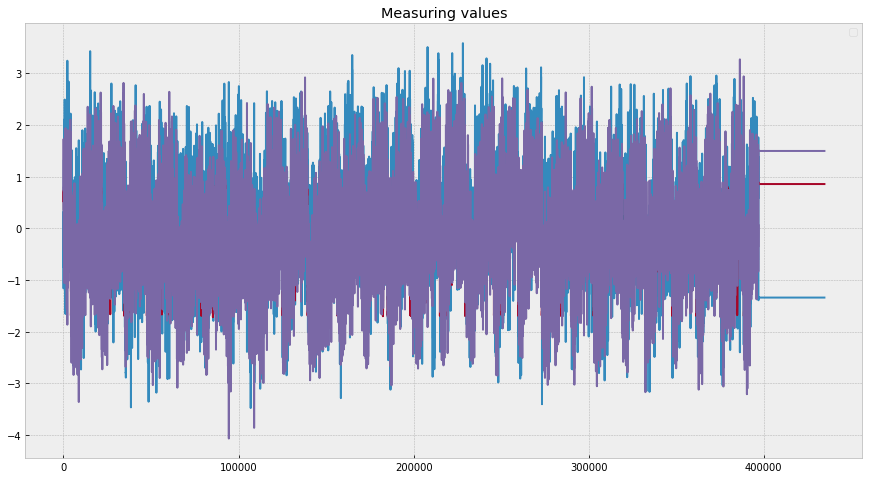

In [10]:
#строим обрезанные данные 
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Measuring values')
    df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df))
    #df_rescaled = pd.DataFrame(MinMaxScaler(feature_range=(-1, 1)).fit_transform(df))
    for k in df_rescaled.columns:
        plt.plot(df_rescaled[k]);
    plt.legend(loc="best")

In [11]:
#################################Linear regresion - ElasticNet/ SVR
#linear = LinearRegression()
#lasso = Lasso()
#ridge = Ridge()
elasticnet = ElasticNet()
#srv = SVR(kernel='rbf',verbose=True) #C=1e3, gamma=0.1


pca1 = PCA(0.95, random_state = RANDOM_STATE)
scaler1 = StandardScaler()
scaler2 = MinMaxScaler(feature_range=(-1, 1))
srv_pipe = Pipeline([   
                        #('pca1',pca1),                    
                        #('scaler1',scaler1),
                        #('scaler2',scaler2),
                        #('poly', PolynomialFeatures(degree=2)),
                        #('linear', linear) 
                        #('lasso', lasso)
                        #('ridge', ridge)
                        ('elasticnet', elasticnet) 
                        #('srv', srv) 
                        
                        
                        
                        ])

srv_pipe_params = {#'srv__C': np.logspace(-0, 6, 4) 
                    #,'srv__gamma': np.logspace(-4, 1, 4) 
                   #,'srv__loss' : ['epsilon_insensitive','squared_epsilon_insensitive']
                    #'srv__kernel: ['rbf', 'linear','poly'] 
                    
                    #'lasso__alpha' : np.logspace(-4, 2, 4) 
                    #'linear__fit_intercept ' : [True,False] 
                    #'ridge__alpha' : np.logspace(0, 4, 4)
                    'elasticnet__alpha' : np.logspace(-4, -1, 3) 
                    ,'elasticnet__l1_ratio' : np.logspace(-2, 1, 2) 
                    }
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)  

model = GridSearchCV(srv_pipe, cv=5, param_grid=srv_pipe_params, scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)

model.fit(X_train.reshape(-1, 16), y_train[:,])
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


Best: -0.712320 using {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.01}
-0.712320 (0.221097) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.01}
-0.714897 (0.222201) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 10.0}
-0.725022 (0.226319) with: {'elasticnet__alpha': 0.0031622776601683794, 'elasticnet__l1_ratio': 0.01}
-0.738978 (0.229502) with: {'elasticnet__alpha': 0.0031622776601683794, 'elasticnet__l1_ratio': 10.0}
-0.748467 (0.224426) with: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.01}
-2.166237 (0.162508) with: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 10.0}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111424.55872918839, tolerance: 74.67242855337962
  positive)


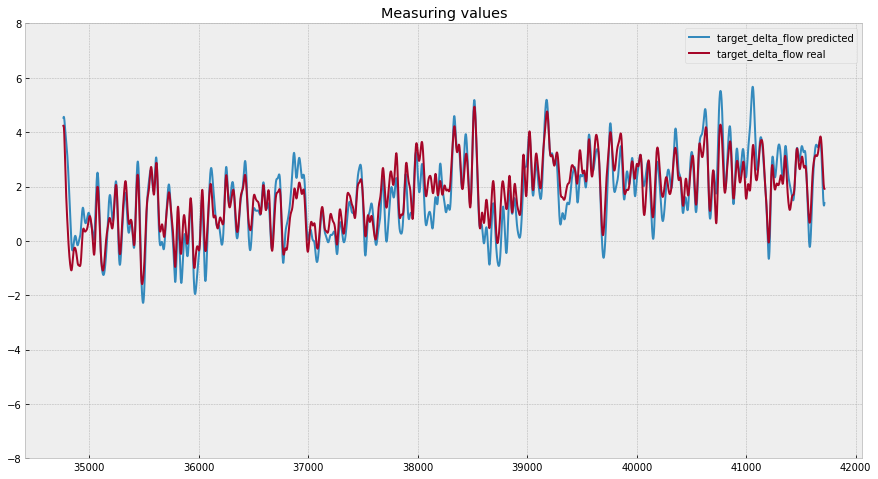

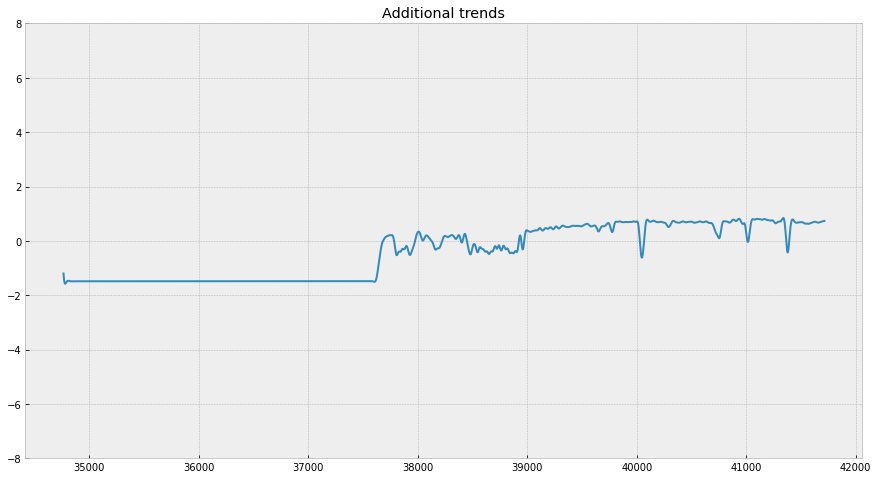

In [12]:
plot_predicted(X_train,y_train,model,range_low = 0.10,range_high=0.12, range_up = 8, range_down = -8, extra_plot=[1])

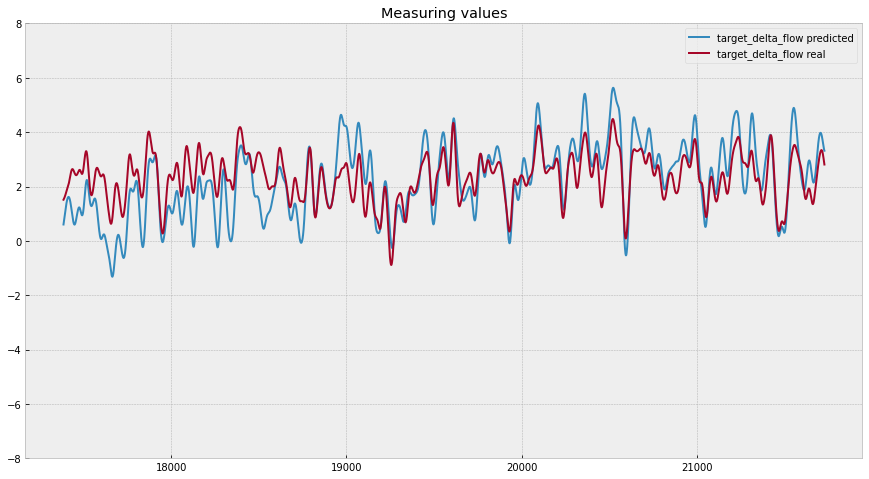

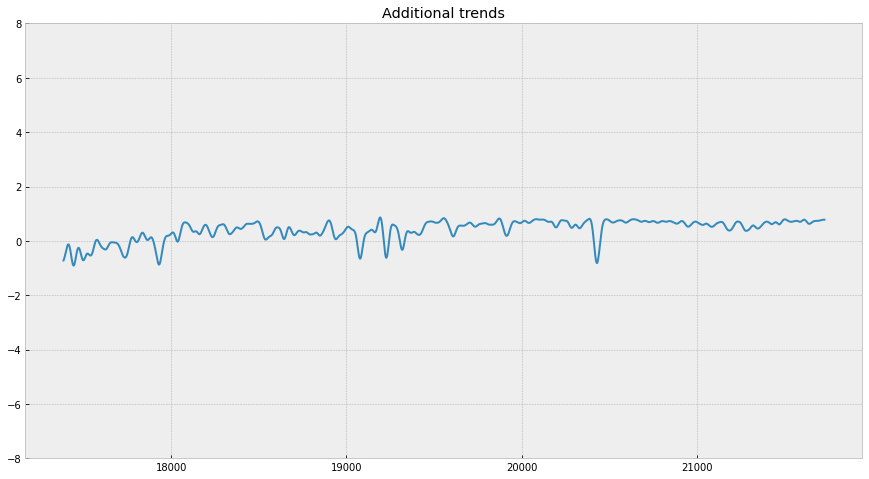

In [18]:
plot_predicted(X_test,y_test,model,range_low = 0.2,range_high=0.25, range_up = 8, range_down = -8, extra_plot=[1])

In [ ]:
#####################TEST CELLL####################

df_t = pd.read_csv('./data/export_20171026.txt', sep=csv_separator ,header = 0 )
df_t.columns = columns_input
df_t.dropna(inplace=True)

#df_t['line_2_out_flow'] = df_t['line_2_out_flow']
b, a = signal.butter(3, 0.05)
#zi = signal.lfilter_zi(b, a)
#z, _ = signal.lfilter(b, a, np.array(df_t['line_2_out_flow']), zi=zi*np.array(df_t['line_2_out_flow'])[0])



df_t['line_2_out_flow_filtered']= signal.filtfilt(b, a, np.array(df_t['line_2_out_flow']))

#Plot data
for k in df_t.columns:
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title("Measuring %s"%k)
        plt.plot(df_t[k].iloc[0:1000]);
        plt.legend(loc="best")

In [ ]:
#####################TEST CELLL####################
df_t = pd.read_csv('./data/export_20171026.txt', sep=csv_separator ,header = 0 )
df_t.columns = columns_input
df_t.dropna(inplace=True)

#df_t['line_2_out_flow'] = df_t['line_2_out_flow']
b, a = signal.butter(3, 0.02)
#zi = signal.lfilter_zi(b, a)
#z, _ = signal.lfilter(b, a, np.array(df_t['line_2_out_flow']), zi=zi*np.array(df_t['line_2_out_flow'])[0])



df_t['line_2_out_flow_filtered']= signal.filtfilt(b, a, np.array(df_t['line_2_out_flow']))

with plt.style.context('bmh'):
    plt.figure(figsize=(15, 8))
    plt.plot(df_t['line_2_out_flow'].iloc[0:2000]);
    plt.plot(df_t['line_2_out_flow_filtered'].iloc[0:2000]);
    
    plt.legend(loc="best")